In [33]:
import RWTHColors
from RWTHColors import ColorManager
import matplotlib.pyplot as plt
import pandas as pd
import scienceplots

# plt.style.use(['science', 'no-latex', 'rwth'])
plt.style.use(['rwth'])
plt.rc('font', family='serif')
cm = ColorManager()

rwth_colors = {
    'hydro reservoir': cm.RWTHBlau(),
    'bio gas cogen': cm.RWTHGruen(),
    'hydro_run_of_river': None,
    'photovoltaic': cm.RWTHGelb(),
    'lignite': None,
    'wood chips cogen': cm.RWTHRot(),
    'natural gas boiler': None,
    'wind offshore': None,
    'wind onshore': cm.RWTHTuerkis(),
    'fuel cell cogen': cm.RWTHOrange(),
}
name = "time_explicit_t50_v8"
df_scaling = pd.read_csv(f"results/{name}_opt_scaling.csv", index_col=0)
df_demand = pd.read_csv(f"results/{name}_opt_demand.csv", index_col=0)
df_elec_prod = pd.read_csv(f"results/{name}_opt_electricity.csv", index_col=0)
df_heat_prod = pd.read_csv(f"results/{name}_opt_heat.csv", index_col=0)

In [34]:
df_scaling = df_scaling.loc[2020:2051]
df_demand_elec = df_demand.filter(like='electricity')
df_demand_heat = df_demand.filter(like='heat')

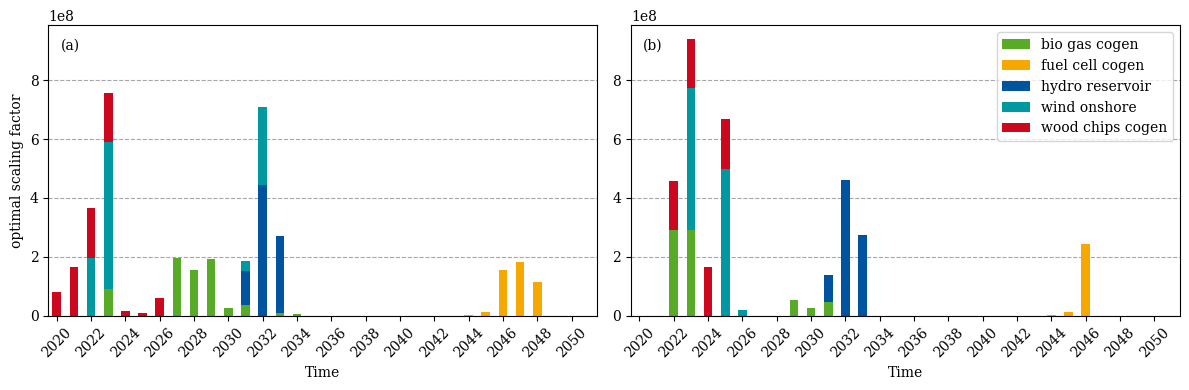

In [35]:
df_scaling_time_explcit = pd.read_csv(f"results/time_explicit_t50_v8_opt_scaling.csv", index_col=0)
df_scaling_static = pd.read_csv(f"results/static_v8_opt_scaling.csv", index_col=0)
df_scaling_time_explcit = df_scaling_time_explcit.loc[2020:2051]
df_scaling_static = df_scaling_static.loc[2020:2051]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))

df_scaling_time_explcit_nonzero = df_scaling_time_explcit.loc[:, (df_scaling_time_explcit != 0).any(axis=0)]
df_scaling_static_nonzero = df_scaling_static.loc[:, (df_scaling_static != 0).any(axis=0)]

df_scaling_time_explcit_nonzero = df_scaling_time_explcit_nonzero.filter(like='elec', axis=1)
df_scaling_static_nonzero = df_scaling_static_nonzero.filter(like='elec', axis=1)

df_scaling_time_explcit_nonzero.columns = ["_".join(col.split("_")[2:]) for col in df_scaling_time_explcit_nonzero.columns]
df_scaling_static_nonzero.columns = ["_".join(col.split("_")[2:]) for col in df_scaling_static_nonzero.columns]

df_scaling_time_explcit_nonzero.columns = [col.replace('_', ' ') for col in df_scaling_time_explcit_nonzero.columns]
df_scaling_static_nonzero.columns = [col.replace('_', ' ') for col in df_scaling_static_nonzero.columns]


df_scaling_time_explcit_nonzero.plot(kind='bar', stacked=True, ax=ax1, color=[rwth_colors.get(col, 'black') for col in df_scaling_time_explcit_nonzero.columns], legend=False)
df_scaling_static_nonzero.plot(kind='bar', stacked=True, ax=ax2, color=[rwth_colors.get(col, 'black') for col in df_scaling_static_nonzero.columns], legend=True)

# Set the same y-axis limits for both subplots
y_max = max(ax1.get_ylim()[1], ax2.get_ylim()[1])
ax1.set_ylim(0, y_max)
ax2.set_ylim(0, y_max)


for ax in [ax1, ax2]:
    ax.yaxis.grid(True, linestyle='--', which='both', color='grey', alpha=0.7)
    ax.set_axisbelow(True)

fig.text(0.055, 0.89, '(a)', transform=fig.transFigure, verticalalignment='top')
fig.text(0.54, 0.89, '(b)', transform=fig.transFigure, verticalalignment='top')

ax1.set_xticks(range(0, len(df_scaling_time_explcit.index), 2))
ax1.set_xticklabels(df_scaling_time_explcit.index[::2], rotation=45)
ax2.set_xticks(range(0, len(df_scaling_static.index), 2))
ax2.set_xticklabels(df_scaling_static.index[::2], rotation=45)
ax1.set_ylabel("optimal scaling factor")

plt.tight_layout()
plt.show()
fig.savefig(f"figures/scaling_comparison.png")

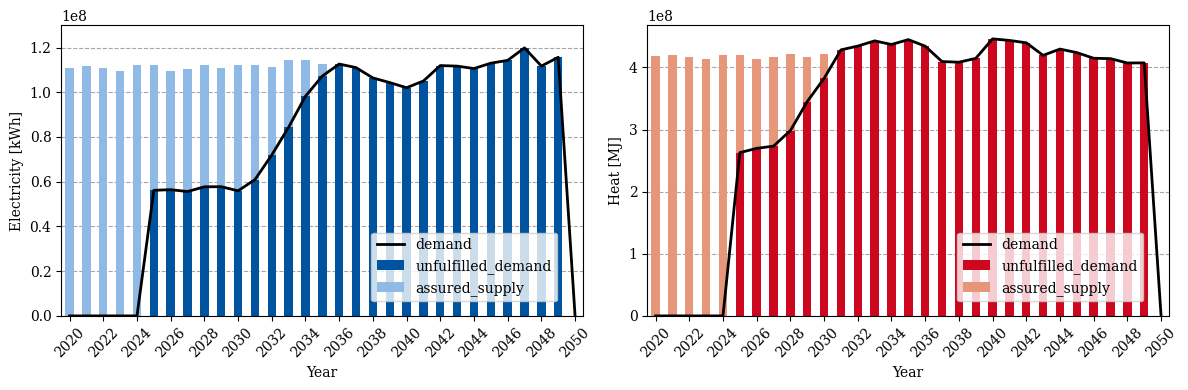

In [100]:
import numpy as np

# Create copies of the demand dataframes
df_demand_plot = {}

for energy_type, df in zip(['elec', 'heat'], [df_demand_elec, df_demand_heat]):
    df_copy = df.copy()
    np.random.seed(42)  # For reproducibility
    if energy_type == 'elec':
        df_copy['x_demand'] = np.maximum(0, 111687000.0 - (df.values + np.random.normal(0, 1500000, df.shape)))
    else:
        df_copy['x_demand'] = np.maximum(0, 419441000.0 - (df.values + np.random.normal(0, 3700000, df.shape)))
    df_copy.loc[2036:, 'x_demand'] = 0
    df_copy = df_copy.loc[2020:2050]
    df_copy.columns = ['unfulfilled_demand', 'assured_supply']
    df_copy = df_copy.reset_index(drop=True)
    df_demand_plot[energy_type] = df_copy

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))

for ax, (energy_type, df) in zip([ax1, ax2], df_demand_plot.items()):
    color = [cm.RWTHBlau(100), cm.RWTHBlau(50)] if energy_type == 'elec' else [cm.RWTHRot(100), cm.RWTHRot(50)]
    df.plot(kind='bar', stacked=True, ax=ax, color=color + ['black'], legend=False)

    df['unfulfilled_demand'].plot(ax=ax, color='black', linewidth=2, label='demand')
    ax.set_ylabel("Electricity [kWh]" if energy_type == 'elec' else "Heat [MJ]")
    ax.set_ylim(0, 1.3e8 if energy_type == 'elec' else 3.6*1.3e8)
    ax.set_xlabel("Year")
    ax.set_xticks(range(0, len(df.index), 2))
    ax.set_xticklabels(range(2020, 2020 + len(df), 2), rotation=45)
    ax.yaxis.grid(True, linestyle='--', which='both', color='grey', alpha=0.7)
    ax.set_axisbelow(True)
    ax.legend(loc="lower right", bbox_to_anchor=(0.95, 0.05), borderaxespad=0.)

plt.tight_layout()
plt.show()
# fig.savefig(f"figures/demand_combined.png", dpi=300)

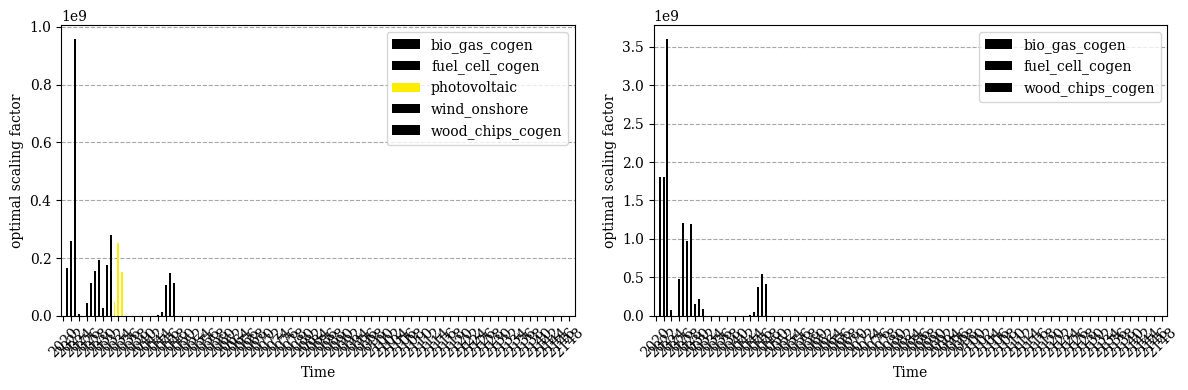

In [31]:
# Scaling

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))
df_scaling_nonzero = df_scaling.loc[:, (df_scaling != 0).any(axis=0)]

df_elec_scale = df_scaling_nonzero.filter(like='elec')
df_heat_scale = df_scaling_nonzero.filter(like='heat')

df_elec_scale.columns = ["_".join(col.split("_")[2:]) for col in df_elec_scale.columns]
df_heat_scale.columns = ["_".join(col.split("_")[2:]) for col in df_heat_scale.columns]

df_elec_scale.plot(kind='bar', stacked=True, ax=ax1, color=[rwth_colors.get(col, 'black') for col in df_elec_scale.columns], legend=True)
df_heat_scale.plot(kind='bar', stacked=True, ax=ax2, color=[rwth_colors.get(col, 'black') for col in df_heat_scale.columns], legend=True)

for ax in [ax1, ax2]:
    ax.yaxis.grid(True, linestyle='--', which='both', color='grey', alpha=0.7)
    ax.set_axisbelow(True)

ax1.set_xticks(range(0, len(df_scaling.index), 2))
ax1.set_xticklabels(df_scaling.index[::2], rotation=45)
ax2.set_xticks(range(0, len(df_scaling.index), 2))
ax2.set_xticklabels(df_scaling.index[::2], rotation=45)
ax1.set_ylabel("optimal scaling factor")
ax2.set_ylabel("optimal scaling factor")

plt.tight_layout()
plt.show()
fig.savefig(f"figures/{name}_scaling.png")

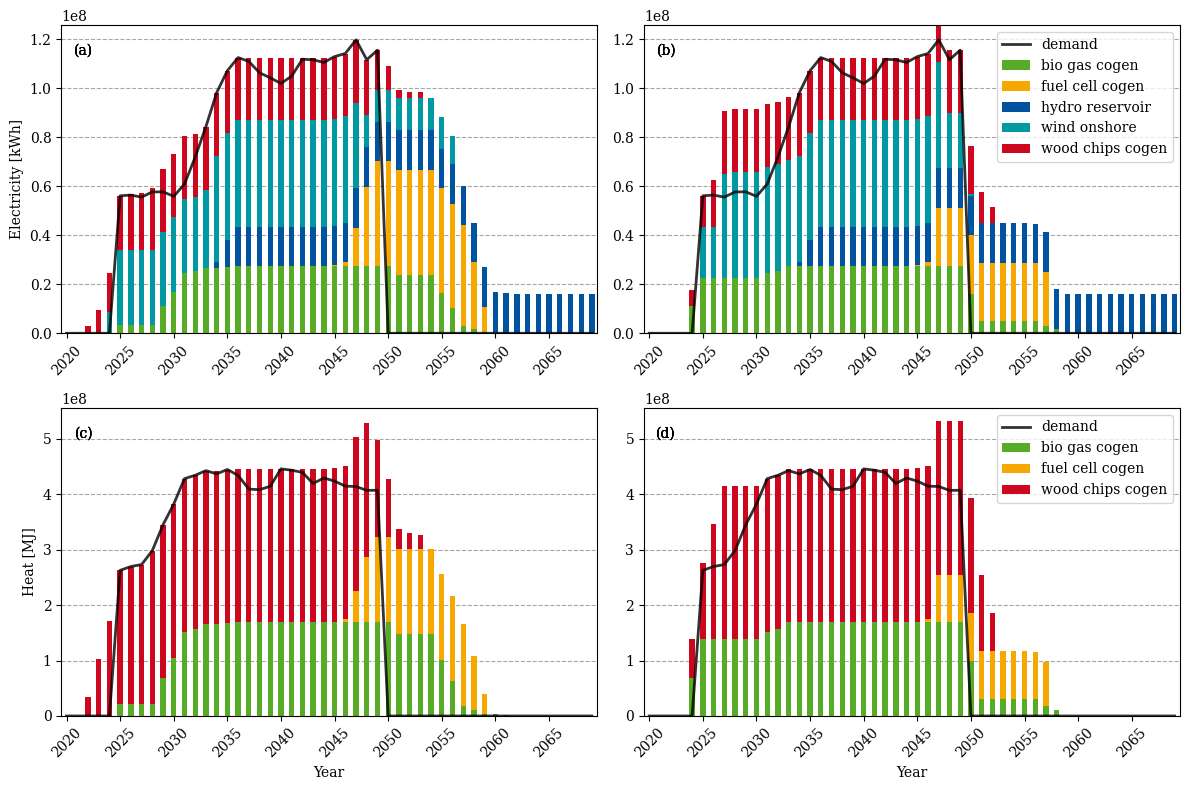

In [36]:
df_elec_prod_time_explicit = pd.read_csv("results/time_explicit_t50_v8_opt_electricity.csv", index_col=0)
df_heat_prod_time_explicit = pd.read_csv("results/time_explicit_t50_v8_opt_heat.csv", index_col=0)
df_elec_prod_static = pd.read_csv("results/static_v8_opt_electricity.csv", index_col=0)
df_heat_prod_static = pd.read_csv("results/static_v8_opt_heat.csv", index_col=0)
df_demand = pd.read_csv("results/time_explicit_t50_v8_opt_demand.csv", index_col=0)

df_demand_elec = df_demand.filter(like='electricity')
df_demand_heat = df_demand.filter(like='heat')

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for i, (prod_df, demand_df, ax, label) in enumerate(zip(
    [df_elec_prod, df_elec_prod_static, df_heat_prod, df_heat_prod_static], 
    [df_demand_elec, df_demand_elec, df_demand_heat, df_demand_heat], 
    axes.flatten(), 
    ['elec', 'elec', 'heat', 'heat']
)):
    # Filter non-zero production columns
    prod_nonzero = prod_df.loc[:, (prod_df != 0).any(axis=0)]
    prod_nonzero.columns = ["_".join(col.split("_")[2:]) for col in prod_nonzero.columns]

    # Reindex to 0 to length and store the original index
    prod_nonzero = prod_nonzero.reset_index(drop=True)
    demand_df = demand_df.reset_index(drop=True)
    demand_df.columns = ["demand"]

    prod_nonzero.columns = [col.replace('_', ' ') for col in prod_nonzero.columns]

    # Plot bar chart (stacked)
    prod_nonzero.plot(
        kind='bar',
        stacked=True,
        ax=ax,
        color=[rwth_colors.get(col, 'gray') for col in prod_nonzero.columns],
        legend=True
    )

    # Plot demand line
    demand_df["demand"].plot(
        ax=ax,
        color='black',
        alpha=0.8,
        linewidth=2,
        label='demand'
    )

    # Customize axes
    if i == 1 or i == 3:
        ax.legend(loc='upper right')
    else:
        ax.legend().set_visible(False)
    ax.yaxis.grid(True, linestyle='--', which='both', color='grey', alpha=0.7)
    ax.set_axisbelow(True)

    # Fix x-axis labels
    years = list(range(2020, 2020 + len(prod_nonzero)))  # Recreate original year labels
    ax.set_xticks(range(0, len(years), 5))  # Show every 5th year
    ax.set_xticklabels(years[::5], rotation=45)

    # Add titles and labels
    ax.set_xlabel("Year")
    ax.set_ylabel("Electricity [kWh]" if label == 'elec' else "Heat [MJ]")

    # Remove y labels on right figures
    if i % 2 != 0:
        ax.set_ylabel("")

    # Remove x labels on top figures
    if i < 2:
        ax.set_xlabel("")

    # Set the same y-axis limits for both top and both bottom subplots
    if i < 2:
        y_max_top = max(axes[0, 0].get_ylim()[1], axes[0, 1].get_ylim()[1])
        axes[0, 0].set_ylim(0, y_max_top)
        axes[0, 1].set_ylim(0, y_max_top)
    else:
        y_max_bottom = max(axes[1, 0].get_ylim()[1], axes[1, 1].get_ylim()[1])
        axes[1, 0].set_ylim(0, y_max_bottom)
        axes[1, 1].set_ylim(0, y_max_bottom)

    # Add labels (a, b, c, d) to the top left corner of each subplot
    labels = ['(a)', '(b)', '(c)', '(d)']
    for ax, label in zip(axes.flatten(), labels):
        ax.text(0.06, 0.94, label, transform=ax.transAxes, va='top', ha='right')

# Tight layout for spacing
plt.tight_layout()
plt.show()
fig.savefig(f"figures/production.png", dpi=300)
